# Backtesting

First, imports

In [2]:
%pwd

'/Users/eaglehawkinator/Documents/Python Finance Projects/PaperTrading/Testing'

In [3]:
%cd ..

/Users/eaglehawkinator/Documents/Python Finance Projects/PaperTrading


In [98]:
import statistics

import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy, TrailingStrategy, crossover
from backtesting.test import GOOG

import config

## Example Test Strategy

In [ ]:
table = pd.read_html('https://stockmarketmba.com/stocksinthenasdaq100.php')
tickers = table[1]['Symbol'].to_list()
print(tickers)

In [ ]:
GOOG.tail()

In [ ]:
def SMA(values, n):
    return pd.Series(values).rolling(n).mean()

In [ ]:
class SmaCross(Strategy):

    n1 = 10
    n2 = 20

    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell

In [ ]:
bt = Backtest(GOOG, SmaCross, cash=10_000, commission=0.002)
stats = bt.run()
stats

In [ ]:
#to get the items from stats (return % is index 6)
list(stats.items())

## Now try on the real strategy

Now iterate through the universe of tickers and aggregate the data from the entire test

In [ ]:
table = pd.read_html('https://stockmarketmba.com/stocksinthenasdaq100.php')
tickers = table[1]['Symbol'].to_list()
print(tickers)

In [ ]:
def SMA(values, n):
    return pd.Series(values).rolling(n).mean()

In [ ]:
class SmaCross(Strategy):

    n1 = 10
    n2 = 30

    def init(self):
        super().init()
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)

    def next(self):
        super().next()
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell

In [ ]:
returns = []

for ticker in tickers:
    df = yf.Ticker(ticker).history(period='10000m', interval='5m')
    try:
        bt = Backtest(df, SmaCross, cash=10_000, commission=0.002)
        stats = bt.run()
    except ValueError:
        continue
    
    returns.append(list(stats.items())[6][1])

print(statistics.mean(returns))

Returns don't look so good. This could be because the "edge" is gone since the google data in the previous example was collected (2013-2015), it could have to do with the timeframe (intraday in our example vs interday in the above example), or that strategy on Google stock could have been an outlier and this average of many tickers shows a better picture of actual returns.

 Let's try to optimize the parameter variables for each ticker and average them together

In [ ]:
n1 = []
n2 = []

for ticker in tickers:
    df = yf.Ticker(ticker).history(period='10000m', interval='5m')
    try:
        bt = Backtest(df, SmaCross, cash=10_000, commission=0.002)
        stats = bt.optimize(
            roll=range(10, 60, 5),
            maximize="Equity Final [$]",
            constraint=lambda p: p.roll > 10,
        )
    except ValueError:
        continue
    print(stats['_strategy'])

stats = bt.optimize(
    roll=range(10, 60, 5),
    maximize="Equity Final [$]",
    constraint=lambda p: p.roll > 10,
)


## Linear Regression Strategy

Now that we've established that the previous SMA Crossover strategy does not have great potential for returns, let's try a new strategy. In this one I want to use linear regression to try to predict price movement.

One benefit of this approach is that the portfolio class will have some additional info (coefficients and standard errors) to go on when making decisions. It can allocate more funds to strategies with higher returns/lower variance or vice versa.

In [4]:
import inspect
import statistics
import datetime

import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import config

Let's start with an arbitrary stock from our list of tickers, NFLX

In [5]:
NFLX = yf.Ticker('NFLX').history(period='10d', interval='5m')
NFLX.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-09-01 15:35:00-04:00,439.975006,440.149994,439.660004,439.769989,43131,0.0,0.0
2023-09-01 15:40:00-04:00,439.819885,440.040009,439.470001,439.480011,33146,0.0,0.0
2023-09-01 15:45:00-04:00,439.515015,439.670013,439.029999,439.494995,46298,0.0,0.0
2023-09-01 15:50:00-04:00,439.429993,439.850006,439.119995,439.769989,86588,0.0,0.0
2023-09-01 15:55:00-04:00,439.899994,440.160004,439.489990,440.040009,164192,0.0,0.0


Now let's fit a simple linear regression over the whole period chosen

In [13]:
x = np.array(sm.add_constant(NFLX.index))
y = NFLX['Close']
mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     1388.
Date:                Mon, 04 Sep 2023   Prob (F-statistic):          3.60e-175
Time:                        13:04:11   Log-Likelihood:                -2638.4
No. Observations:                 780   AIC:                             5281.
Df Residuals:                     778   BIC:                             5290.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        406.3373      0.510    796.113      0.0

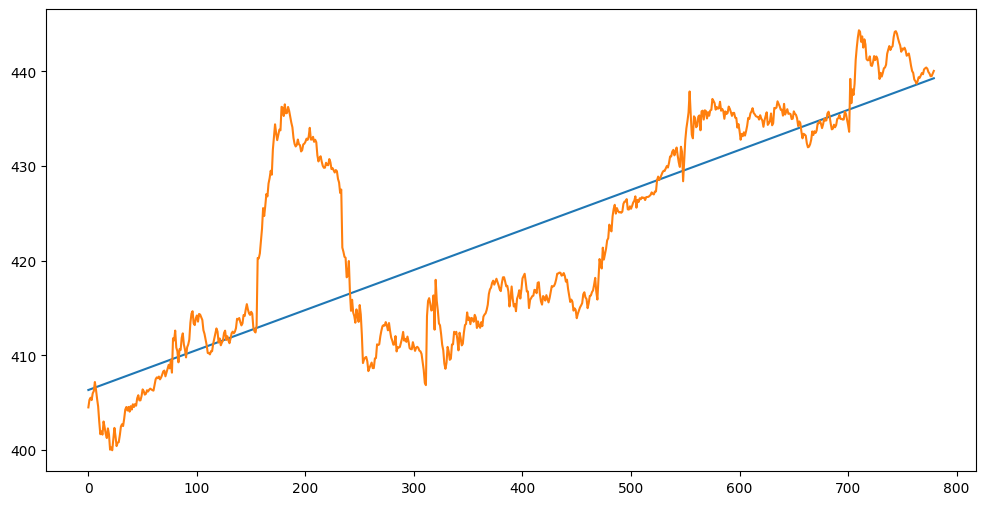

In [35]:
y_ols = []
for x in NFLX.index:
    y_ols.append(res.params[0] + x * res.params[1])

plt.figure(figsize=(12,6))
plt.plot(NFLX.index, y_ols)
plt.plot(NFLX.index, NFLX['Close'])
plt.show()

Now that we have a simple linear regression, let's do a rolling linear regression

In [21]:
NFLX.reset_index(drop=True, inplace=True)

window_size = 60

x = np.array(sm.add_constant(NFLX.index.tolist()))
y = np.array(NFLX['Close'])

rols = RollingOLS(y, x, window_size)
rres = rols.fit()

params = pd.DataFrame(rres.params.copy())

params.tail()


,0,1
775,460.465790,-0.025921
776,460.312122,-0.025756
777,461.994769,-0.028012
778,463.444855,-0.029943
779,464.475030,-0.031303


In [28]:
def plot_rols(params:pd.DataFrame):
    x_plot = []
    y_plot = []
    for x in params.index.tolist():
        x_plot.append(x)
        y_plot.append(params.loc[x,0] + x * params.loc[x, 1])
    return x_plot, y_plot

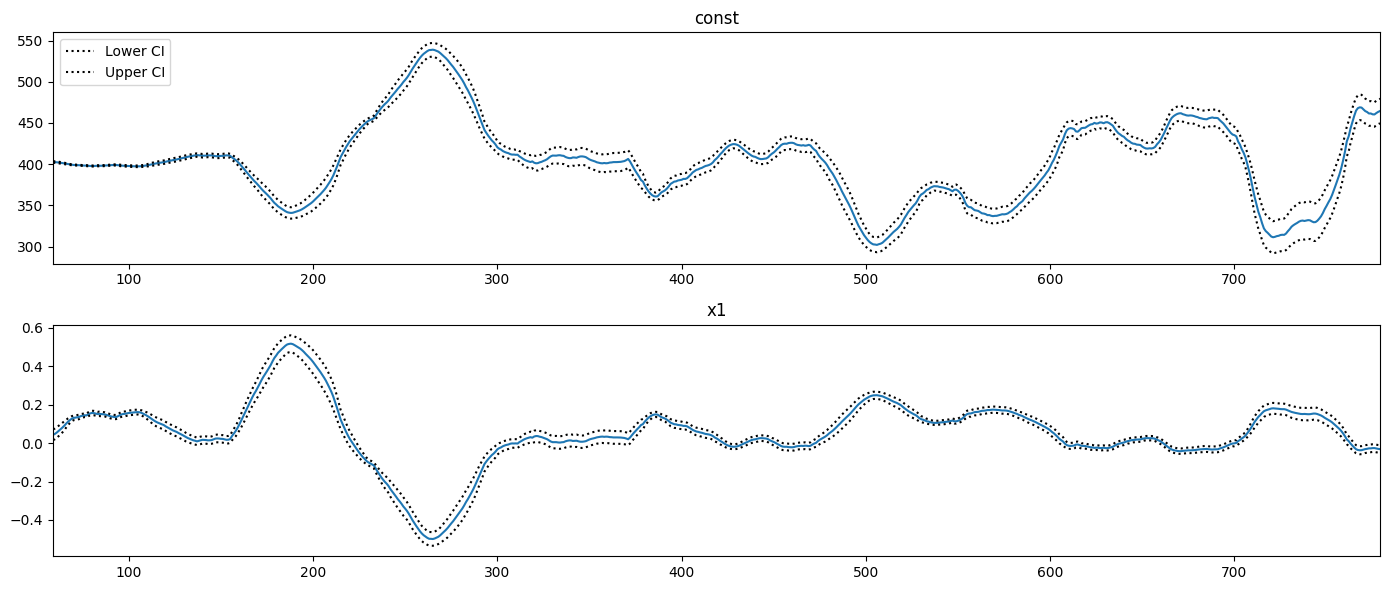

In [29]:
fig = rres.plot_recursive_coefficient(variables=['const', 'x1'], figsize=(14, 6))

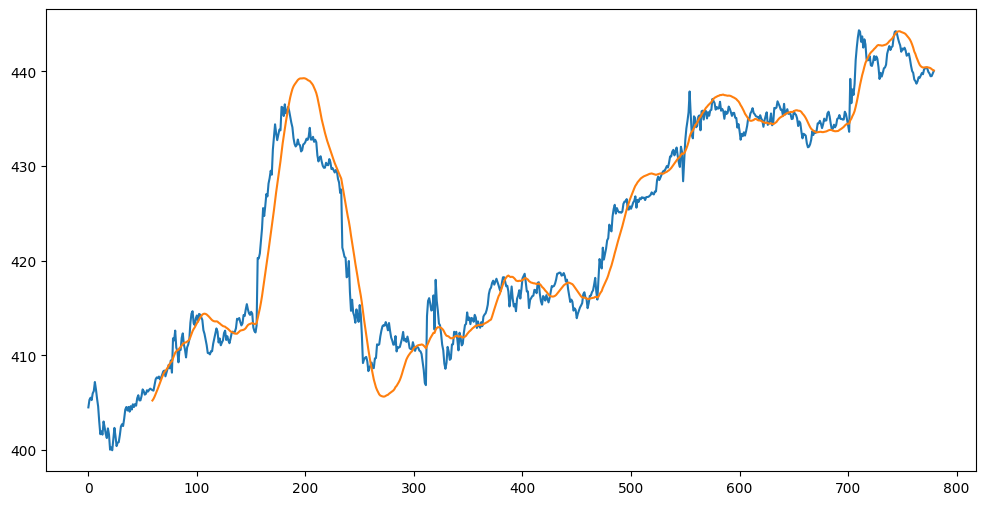

In [30]:
x_plot, y_plot = plot_rols(params)
plt.figure(figsize=(12,6))
plt.plot(NFLX.index.to_list(), NFLX['Close'])
plt.plot(x_plot, y_plot)
plt.show()

Now, let's see what happens when we plot the simple OLS and rolling OLS on top of the price movement together

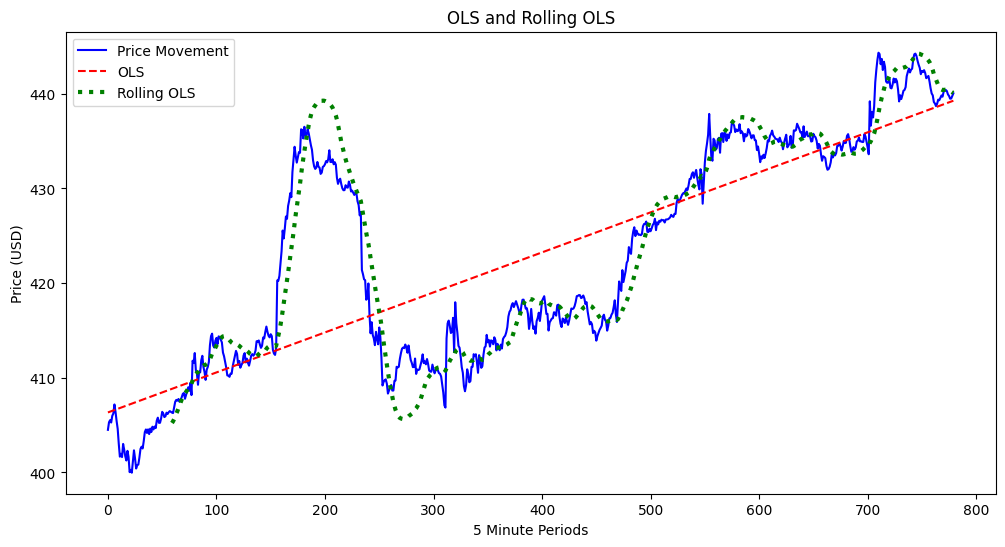

In [55]:
plt.figure(figsize=(12,6))
plt.plot(NFLX.index, NFLX['Close'], color='blue', label='Price Movement')
plt.plot(NFLX.index, y_ols, color='red', label='OLS', linestyle='--')
plt.plot(x_plot, y_plot, color='green', label='Rolling OLS', linestyle=':', linewidth=3)
plt.legend()
plt.title('OLS and Rolling OLS')
plt.ylabel('Price (USD)')
plt.xlabel('5 Minute Periods')
plt.show()